In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F54339%2F104884%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240818%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240818T112518Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4c1159062ef386cba2f4e1d8b7036765a60cb6a210725630d4645181e9245cf7e18ca044a8ee29fd594e2a3376b17330f706277553980e6180da43e63b71530f00892b3467cce3bfac8fa26257216ea5632f997fa754322c7a4a4572e94e18d330749c418f6595c85685be8e08d3415ce2a6e76efe4b11976e35c9091e026de4ffd43bfc23fd89aa9d0d462060e1d26756f04aaa247a3930aea3d927137c35a636ed4d82aca2ee650f61733fb1af6ac3681ff880d83b491d446543cb5a80d575db7d9ae68f592e3bad0dbfe3770e063f64920df0abc237a3582cbf7260e6efc689c867f13e23338512d66a915f6a13c60d8a88d067e7211feafb34395756e2aa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5582914511 bytes downloaded
Downloaded and uncompressed: 
Data source import complete.


In [ ]:
# moutn google drive for saving model
from google.colab import drive
drive.mount('/content/drive')

model_save_path = "/content/drive/MyDrive/best_model_EffB0.keras"

Mounted at /content/drive


In [ ]:
# General
import os, pickle
from pathlib import Path
from tqdm import tqdm

# Data manipulation
import pandas as pd
import numpy as np
from random import sample, shuffle
from sklearn import metrics, model_selection
from math import ceil

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Image manipulation
import PIL, cv2
from skimage.io import imread, imshow

# Visualizations
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Matplotlib options
plt.rcParams['font.size']=14

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

from tensorflow.keras.applications.efficientnet import preprocess_input as base_preprocess


In [ ]:
def bar_plt(y, x, title):
    sns.barplot(y=y, x=x, palette="dark")
    plt.xticks(rotation=60, fontsize=11)
    plt.yticks(fontsize=14)
    plt.title(title, fontsize=14, pad=20)

def show_examples(df, col, n_samples = 5):
    "Show `n_samples` of each type of value in `col` of dataframe `df`"
    groups = df.sort_values([col]).groupby(col)
    n_rows = len(groups)
    fig, m_axs = plt.subplots(n_rows, n_samples, figsize = (3*n_samples, 2*n_rows))
    for n_axs, (type_name, type_rows) in zip(m_axs,groups):
        n_axs[0].set_title(type_name)
        for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples).iterrows()):
            c_ax.imshow(imread(c_row['path']))
            c_ax.axis('off')

In [ ]:
data_path = Path("/kaggle/input")
print(os.listdir(data_path))
csv_path = data_path / 'HAM10000_metadata.csv'
df_data=pd.read_csv(csv_path).set_index('image_id')
df_data["image_id"] = df_data.index
df_data.head()

['hmnist_8_8_RGB.csv', 'ham10000_images_part_1', 'hmnist_8_8_L.csv', 'HAM10000_images_part_2', 'ham10000_images_part_2', 'HAM10000_images_part_1', 'hmnist_28_28_RGB.csv', 'HAM10000_metadata.csv', 'hmnist_28_28_L.csv']


,lesion_id,dx,dx_type,age,sex,localization,image_id
image_id,,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp,ISIC_0027419
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp,ISIC_0025030
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp,ISIC_0026769
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp,ISIC_0025661
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear,ISIC_0031633


In [ ]:
from sklearn.utils import shuffle
seed = 0
df_data = shuffle(df_data, random_state=seed)

In [ ]:
# unzip aug images to colab
!unzip '/content/drive/MyDrive/ham10000/aug_images.zip' -d /

Streaming output truncated to the last 5000 lines.
  inflating: /kaggle/working/HAM10000_augmented_part_3/ISIC_0026090_0_6369.jpg  
  inflating: /kaggle/working/HAM10000_augmented_part_3/ISIC_0029362_0_4011.jpg  
  inflating: /kaggle/working/HAM10000_augmented_part_3/ISIC_0027522_0_5490.jpg  
  inflating: /kaggle/working/HAM10000_augmented_part_3/ISIC_0027609_0_4405.jpg  
  inflating: /kaggle/working/HAM10000_augmented_part_3/ISIC_0030782_0_5080.jpg  
  inflating: /kaggle/working/HAM10000_augmented_part_3/ISIC_0031025_0_3336.jpg  
  inflating: /kaggle/working/HAM10000_augmented_part_3/ISIC_0029962_0_3855.jpg  
  inflating: /kaggle/working/HAM10000_augmented_part_3/ISIC_0029034_0_1925.jpg  
  inflating: /kaggle/working/HAM10000_augmented_part_3/ISIC_0031770_0_5657.jpg  
  inflating: /kaggle/working/HAM10000_augmented_part_3/ISIC_0027856_0_1104.jpg  
  inflating: /kaggle/working/HAM10000_augmented_part_3/ISIC_0024330_0_5470.jpg  
  inflating: /kaggle/working/HAM10000_augmented_part_3/ISI

In [ ]:
# for some reason the images are spread over two folders, HAM10000_images_part_1 and ...part_2
# add a column to the df with the path to the correct folders

# {filename : path} for all files in both image folders
imageid_path_dict = {str(x).split('/')[-1][:-4]: str(x) for x in list(data_path.glob('*/*.jpg'))}

# use {filename: path} dict to select items from the correct folders
df_data['path'] = [Path(data_path/imageid_path_dict[fn].split('/')[3]/f'{fn}.jpg') for fn in df_data.index.values]

df_data['image_path'] = (df_data['path'].astype(str))
df_data["image_path"][0]

<ipython-input-6-513cb0d460b2>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_data["image_path"][0]


'/kaggle/input/HAM10000_images_part_1/ISIC_0028664.jpg'

In [ ]:
# Categories of the diferent diseases (thanks to kaggle.com/ingbiodanielh/skin-cancer-classification-with-resnet-50-fastai)
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


df_data.dx=df_data.dx.astype('category',copy=True)
df_data['label']=df_data.dx.cat.codes # Convert the labels to numbers
df_data['lesion_type']= df_data.dx.map(lesion_type_dict)

# create key relating label to lesion_type
label_list = df_data['label'].value_counts().keys().tolist()
lesion_list = df_data['dx'].value_counts().keys().tolist()
label_to_lesion = dict(zip(label_list, lesion_list))
label_to_lesion
df_data.head()

,lesion_id,dx,dx_type,age,sex,localization,image_id,path,image_path,label,lesion_type
image_id,,,,,,,,,,,
ISIC_0028664,HAM_0002695,nv,follow_up,45.0,male,back,ISIC_0028664,/kaggle/input/HAM10000_images_part_1/ISIC_0028...,/kaggle/input/HAM10000_images_part_1/ISIC_0028...,5,Melanocytic nevi
ISIC_0025998,HAM_0000370,nv,follow_up,70.0,male,trunk,ISIC_0025998,/kaggle/input/HAM10000_images_part_1/ISIC_0025...,/kaggle/input/HAM10000_images_part_1/ISIC_0025...,5,Melanocytic nevi
ISIC_0032817,HAM_0006372,nv,histo,35.0,male,back,ISIC_0032817,/kaggle/input/ham10000_images_part_2/ISIC_0032...,/kaggle/input/ham10000_images_part_2/ISIC_0032...,5,Melanocytic nevi
ISIC_0026577,HAM_0006835,nv,histo,75.0,male,chest,ISIC_0026577,/kaggle/input/HAM10000_images_part_1/ISIC_0026...,/kaggle/input/HAM10000_images_part_1/ISIC_0026...,5,Melanocytic nevi
ISIC_0026798,HAM_0005536,bcc,histo,45.0,male,lower extremity,ISIC_0026798,/kaggle/input/HAM10000_images_part_1/ISIC_0026...,/kaggle/input/HAM10000_images_part_1/ISIC_0026...,1,Basal cell carcinoma


In [ ]:
base = "HAM_Dataset"
os.mkdir(base)

os.mkdir(os.path.join(base, "mel"))
os.mkdir(os.path.join(base, "nv"))
os.mkdir(os.path.join(base, "bcc"))
os.mkdir(os.path.join(base, "akiec"))
os.mkdir(os.path.join(base, "bkl"))
os.mkdir(os.path.join(base, "df"))
os.mkdir(os.path.join(base, "vasc"))

print(os.listdir(base))



['akiec', 'df', 'vasc', 'bcc', 'bkl', 'nv', 'mel']


In [ ]:
for index, row in df_data.iterrows():
    label = row["dx"]
    src = os.path.join(row["image_path"])
    file_name = row["image_path"][-16:]
    dst = os.path.join('HAM_Dataset', label, file_name)
    shutil.copyfile(src, dst)

In [ ]:
# get number of non-unique lesion_id's
def check_duplicates(df, col):
    unique_list = df.lesion_id.unique().tolist()
    num_duplicates = len(df) - len(unique_list)
    return num_duplicates

num_duplicates = check_duplicates(df_data, 'lesion_id')
print(f'Duplicate lesion_ids: {num_duplicates} out of {len(df_data)}')

Duplicate lesion_ids: 2545 out of 10015


# New Section Use data augumentation for tackle imbalanced dataset problem

In [ ]:
test_set_fraction = 0.15

# randomly select the test set
df_train, df_val = model_selection.train_test_split(df_data, test_size=test_set_fraction, random_state=seed)

# remove any duplicate images from the test set and check
df_val = df_val.drop_duplicates(subset='lesion_id', keep="first")
num_duplicates = check_duplicates(df_val, 'lesion_id')
print(f'Duplicate lesion_ids: {num_duplicates} out of {len(df_val)}')

# remove any lesions from the train set that are also in the test set
df_train = df_train[~df_train.lesion_id.isin(df_val.lesion_id)]

# finally check test and train dfs have no shared `lesion_ids` or `image_ids`
import collections
check_lesion_ids = df_val['lesion_id'].isin(df_train['lesion_id']).value_counts()
check_image_ids = collections.Counter(df_val.index.isin(df_train.index))
print(f'Test/train overlap? lesion_id: {int(check_lesion_ids) != len(df_val)}, image_id: {check_image_ids[0] != len(df_val)}')

Duplicate lesion_ids: 0 out of 1444
Test/train overlap? lesion_id: False, image_id: False


<ipython-input-55-c5470322e7f2>:18: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print(f'Test/train overlap? lesion_id: {int(check_lesion_ids) != len(df_val)}, image_id: {check_image_ids[0] != len(df_val)}')


In [ ]:
# calculate an augmentation  multiplier for each class
counts = df_train['label'].value_counts()
aug_mults = [(max(counts)/3)//counts[i] for i, c in enumerate(counts)]
aug_mults.sort()
aug_dict = dict(zip(counts.keys(), aug_mults))
print(aug_dict)

# add the multiplier to the training dataframe
df_train['aug_mult'] = df_train['label'].map(lambda x: int(aug_dict.get(x)))

{5: 0.0, 2: 2.0, 4: 2.0, 1: 4.0, 0: 7.0, 6: 16.0, 3: 21.0}


In [ ]:
# create a new folder for augmented images
!rm -r /kaggle/working/HAM10000_augmented_part_3/
aug_dir = Path('/kaggle/working/HAM10000_augmented_part_3')
os.mkdir(aug_dir)

In [ ]:
# Initialize the data generator we will use to create our augmented data

datagen = ImageDataGenerator(
        rescale=None,
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        fill_mode='reflect')

# for each row in `df_trn`, generate 'aug_multplier' augmented images per `base_img` input and save in `aug_dir`
# images saved with filename `base-image-id` + `_0_`+ `number-augmented-image`+'.jpg'

for row in df_train.itertuples():
    inp_img = tf.keras.utils.load_img(row.path)                        # PIL image
    inp_img = tf.keras.utils.img_to_array(inp_img)                     # Numpy array with shape (h, w, ch)
    inp_img = np.expand_dims(inp_img, axis=0)           # add singleton dim (1, h, w, ch)

    counter = 0
    id = row.image_id
    mult = row.aug_mult
    if mult > 1:
        for inp_aug in datagen.flow(inp_img, batch_size = 1, save_to_dir = os.path.join(aug_dir),save_prefix = id, save_format = 'jpg'):
            counter += 1
            if counter >= row.aug_mult: break


In [ ]:
!ls -1 /kaggle/working/HAM10000_augmented_part_3/ | wc -l

9804


In [ ]:
# save augumented images on google drive
#!zip -r /content/aug_images.zip /kaggle/working/HAM10000_augmented_part_3/
!cp /content/aug_images.zip /content/drive/MyDrive/ham10000/

In [ ]:
# prepare a df from augmented image filenames (remember we encoded the base-image-id into the augmented image filename)
aug_items_train_names = os.listdir(str(aug_dir))
print(str(aug_items_train_names[0]))

aug_items_train = [str(aug_dir) + "/" + path for path in aug_items_train_names]

random_state=42
df_train_aug = pd.DataFrame(columns = df_train.columns)
df_train_aug['image_id'] = [x[:-4] for x in aug_items_train_names]
df_train_aug['path'] = aug_items_train


for i, row in enumerate(df_train_aug.itertuples()):
    id = row.image_id.split('_0_')[0]
    r = df_train.loc[df_train['image_id'] == id]
    df_train_aug.at[i, 'dx'] = r.dx.values[0]
    df_train_aug.at[i, 'label'] = r.label.values[0]
    df_train_aug.at[i, 'lesion_id'] = r.lesion_id.values[0]
    df_train_aug.at[i, 'lesion_type'] = r.lesion_type.values[0]

print(f'Num augmented images: {len(df_train_aug)}')

# merge the original and augmented image dataframes
df_train_data = pd.concat([df_train, df_train_aug], ignore_index=True).set_index('image_id')
print(f'Num training images: {len(df_train_data)}')

# add image_path to df
df_train_data['image_path'] = (df_train_data['path'].astype(str))

# Check the balance of the train and test sets
data = df_train_data['label'].value_counts()
bar_plt(data.tolist(), [label_to_lesion[x] for x in data.keys().tolist()], title='Train data')

ISIC_0030442_0_8226.jpg


NameError: name 'df_train' is not defined

# Generate dataset

In [ ]:

IMAGE_SIZE = 224
BATCH_SIZE = 32
validation_split=0.15

In [ ]:
data_dir = 'HAM_Dataset'
batch_size = 32
target_size = (224,224)



from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as base_preprocess


image_gen = ImageDataGenerator(
                               preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               # rescale=1/255,
                               validation_split=0.15)



train_generator = image_gen.flow_from_directory(data_dir,
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

val_generator = image_gen.flow_from_directory(data_dir,
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")

print(train_generator.class_indices)



Found 8516 images belonging to 7 classes.
Found 1499 images belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input as base_preprocess



datagen_aug = ImageDataGenerator(
                                preprocessing_function=base_preprocess,
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest',
                               rescale=1/255,
                               validation_split=validation_split)

datagen_raw = ImageDataGenerator(rescale=1./255,
                                 preprocessing_function=base_preprocess)


datagen_raw_evaluation = ImageDataGenerator(rescale=1./255,
                                 preprocessing_function=base_preprocess,
                                 validation_split=0.8)


train_generator = datagen_aug.flow_from_dataframe(
    dataframe=df_data,
    x_col='image_path',
    y_col='dx',
    color_mode='rgb',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen_aug.flow_from_dataframe(
    dataframe=df_data,
    x_col='image_path',
    y_col='dx',
    color_mode='rgb',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

print(train_generator.class_indices)

Found 8513 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
test_generator = datagen_raw_evaluation.flow_from_dataframe(
    dataframe=df_data,
    x_col='image_path',
    y_col='dx',
    color_mode='rgb',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)


Found 2003 validated image filenames belonging to 7 classes.


In [ ]:


train_generator = datagen_raw.flow_from_dataframe(
  dataframe=df_train_data,
  x_col='image_path',
  y_col='dx',
  target_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
  class_mode='categorical',
  subset="training"
)

val_generator = datagen_raw.flow_from_dataframe(
    dataframe=df_val,
    x_col='image_path',
    y_col='dx',
    color_mode='rgb',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)


print(train_generator.class_indices)

NameError: name 'df_val' is not defined

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object)

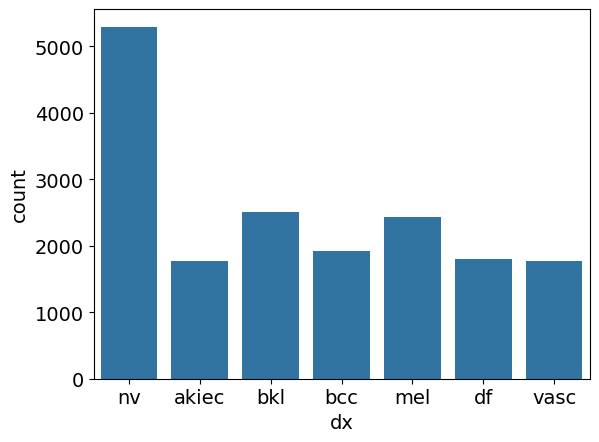

In [ ]:
sns.countplot(x=df_train["dx"])
np.unique(df_data["dx"])
#df_data["dx"]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(df_data["dx"]), y=df_data["dx"])

class_wt_dict=dict(enumerate(class_weights))
class_wt_dict

{0: 4.375273044997815,
 1: 2.78349082823791,
 2: 1.301832835044846,
 3: 12.440993788819876,
 4: 1.2854575792581184,
 5: 0.21338020666879728,
 6: 10.075452716297788}

In [ ]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
# x = Dense(4096, activation='relu')(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation='relu')(x)
# x = Dropout(0.5)(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,379,306 (16.71 MB)

 Trainable params: 4,337,283 (16.55 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
optimizer = Adam(0.0001)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_accuracy',verbose=1)


callback_list = [model_chkpt,lr_reduce]

In [ ]:
history = model.fit(train_generator,
                    epochs=15,
                    class_weight=class_wt_dict,
                    validation_data = val_generator,
                    callbacks=callback_list)

# 722ms/step for flow from dict

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.3155 - loss: 5.7793
Epoch 1: val_accuracy improved from -inf to 0.61975, saving model to /content/drive/MyDrive/best_model_EffB0.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 356s 941ms/step - accuracy: 0.3160 - loss: 5.7777 - val_accuracy: 0.6197 - val_loss: 4.6766 - learning_rate: 1.0000e-04
Epoch 2/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 603ms/step - accuracy: 0.6247 - loss: 4.3234
Epoch 2: val_accuracy improved from 0.61975 to 0.72915, saving model to /content/drive/MyDrive/best_model_EffB0.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 192s 706ms/step - accuracy: 0.6248 - loss: 4.3226 - val_accuracy: 0.7292 - val_loss: 3.7053 - learning_rate: 1.0000e-04
Epoch 3/15
267/267 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.6801 - loss: 3.5298
Epoch 3: val_accuracy improved from 0.72915 to 0.79720, saving model to /content/drive/MyDrive/best_model_EffB0.keras
267/267 ━━━━━━━━━━━━━━━━━━━━ 203s 746ms/step - accuracy: 0.6802 - loss: 3.5292 - val_accuracy: 0.7

In [ ]:
df=pd.DataFrame(model.history.history)

csv_save_path = "/content/drive/MyDrive/model_history_effb0.csv"

df.to_csv(csv_save_path)

<Axes: >

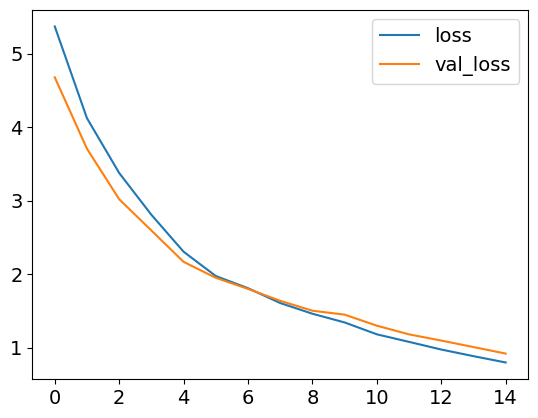

In [ ]:
metrics = pd.DataFrame(model.history.history)
metrics[["loss","val_loss"]].plot()

<Axes: >

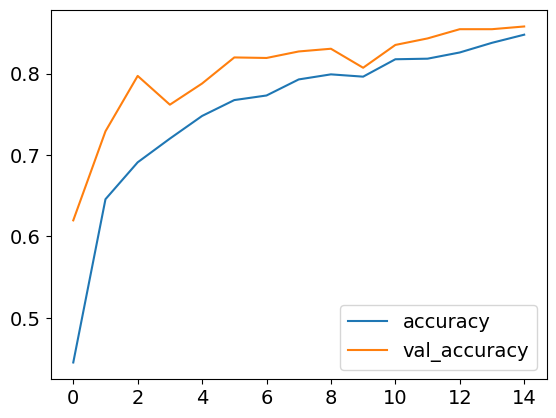

In [ ]:
metrics[["accuracy","val_accuracy"]].plot()

In [ ]:
model.evaluate(val_generator)

47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 580ms/step - accuracy: 0.8440 - loss: 0.8044


[0.7881087064743042, 0.8561917543411255]

In [ ]:
print(model_save_path)
!cp $model_save_path /content/model.keras
!ls -l

/content/drive/MyDrive/best_model_augBalanced.keras
total 213420
drwx------ 5 root root      4096 Aug 18 11:41 drive
-rw------- 1 root root 218530899 Aug 18 11:49 model.keras
drwxr-xr-x 1 root root      4096 Aug 14 13:23 sample_data


In [ ]:
# load model
model = tf.keras.models.load_model("model.keras")

In [ ]:
predictions = model.predict(val_generator, verbose=1)
top_predictions = predictions.argmax(axis=1)
test_labels = val_generator.classes

47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 659ms/step


In [ ]:
import sklearn
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(test_labels, top_predictions)

Normalized confusion matrix
[[0.69387755 0.14285714 0.08163265 0.         0.08163265 0.
  0.        ]
 [0.01298701 0.92207792 0.01298701 0.01298701 0.02597403 0.01298701
  0.        ]
 [0.0304878  0.03658537 0.76829268 0.00609756 0.09146341 0.06707317
  0.        ]
 [0.05882353 0.05882353 0.         0.88235294 0.         0.
  0.        ]
 [0.02409639 0.03614458 0.03614458 0.0060241  0.77710843 0.10843373
  0.01204819]
 [0.00497512 0.0159204  0.0199005  0.00298507 0.05870647 0.89751244
  0.        ]
 [0.         0.         0.04761905 0.         0.         0.
  0.95238095]]


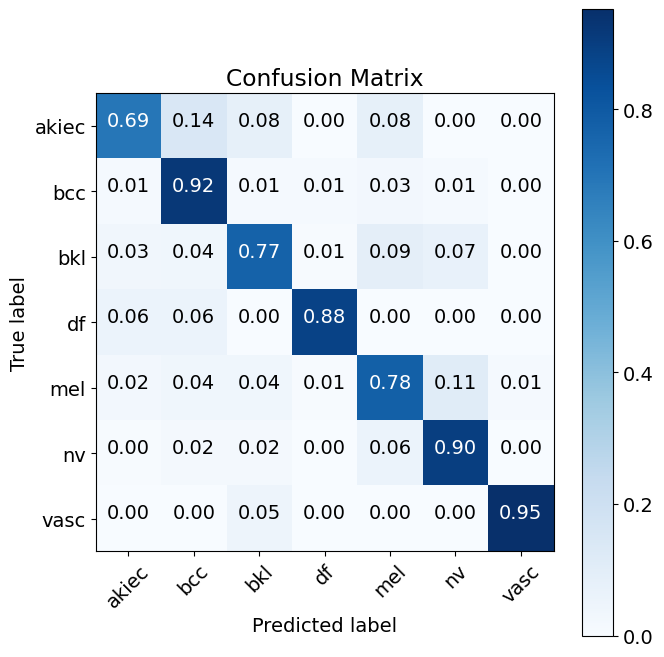

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


cm_plot_labels = list(val_generator.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)


In [ ]:
print(classification_report(test_generator.classes, top_predictions, zero_division=0))

              precision    recall  f1-score   support

           0       0.05      0.02      0.02        61
           1       0.03      0.03      0.03       111
           2       0.13      0.17      0.15       198
           3       0.00      0.00      0.00        29
           4       0.11      0.15      0.12       223
           5       0.68      0.62      0.65      1351
           6       0.00      0.00      0.00        30

    accuracy                           0.46      2003
   macro avg       0.14      0.14      0.14      2003
weighted avg       0.49      0.46      0.47      2003

